## Setup

In [12]:
%matplotlib inline
import numpy as np
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim
import pylab
import random
import pandas as pd
import sqlite3
import networkx as nx
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words

## Data pre-processing

In [62]:
NUMDOCS = 60
NUMTOPICS = 40
COMMENTLIMIT = 20000

In [6]:
f = open('reddit_data/topreddits')
top_subreddits = f.read().splitlines()

In [65]:
# pull the data from reddit
# each subreddit will be read as a 'document' for LDA analysis
sql_conn = sqlite3.connect('reddit_data/database.sqlite')
docs = []
for sub in top_subreddits[0:NUMDOCS]:
    docs += [pd.read_sql(
            "SELECT body FROM May2015 WHERE subreddit = '" + sub + "' LIMIT " + COMMENTLIMIT, 
            sql_conn)]

In [66]:
# turn the dataframes into arrays, then into long strings
str_docs = []
for i in range(len(docs)):
    tostring = ""
    for e in docs[i].as_matrix():
        tostring += e
        tostring += " "
    str_docs += [tostring]

In [67]:
# list for tokenized documents in loop
texts = []
# loop through document list
for doc in str_docs:
    
    # clean and tokenize document string
    raw = doc[0].lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    en_stop = get_stop_words('en') + [u's', u't', u'm',u're', u'can']
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    p_stemmer = PorterStemmer()
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
    

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [68]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics=NUMTOPICS, 
                                           id2word = dictionary, passes=20)
# ldamodel.print_topics(num_words = 20)

## Graphing

In [69]:
# gather all the nodes and put them in the graph
G = nx.Graph()
fig = plt.figure(figsize=(12,12))
strdict = {}
for i in range(len(str_docs)):
    strdict[i] = str_docs[i]
G.add_nodes_from(range(len(strdict)))

In [70]:
## color everything based on its most prominent topic ##

# generate colors for each topic
NUMCOLORS = NUMTOPICS
raw_cols = []
currentcol = 5.0
for i in range(NUMCOLORS):
    raw_cols += ["#%06x" % random.randint(0xa982ff, 0xFFFFFF)]

# assign colors to nodes
cols = []
labels = {}
for i in range(NUMDOCS):
    labels[i] = top_subreddits[i]
    doctopic = ldamodel.get_document_topics(corpus[i])[0][0] % len(raw_cols)
    cols += [raw_cols[doctopic]]


In [60]:
# set how close two subreddits need to be for a line to be drawn
THRESH = 180

# draw edges where lengths correspond to similarity
# of word distributions
for i in range(len(str_docs)):
    j = i + 1
    while j < len(str_docs):
        dist = gensim.matutils.hellinger(corpus[i], corpus[j])
        # also useful: cosine similarity
        # dist = gensim.matutils.cossim(corpus[i], corpus[j])
        if dist < THRESH:
            # print top_subreddits[i] + ", " + top_subreddits[j]
            G.add_edge(i, j, length = dist)
        j = j+1      

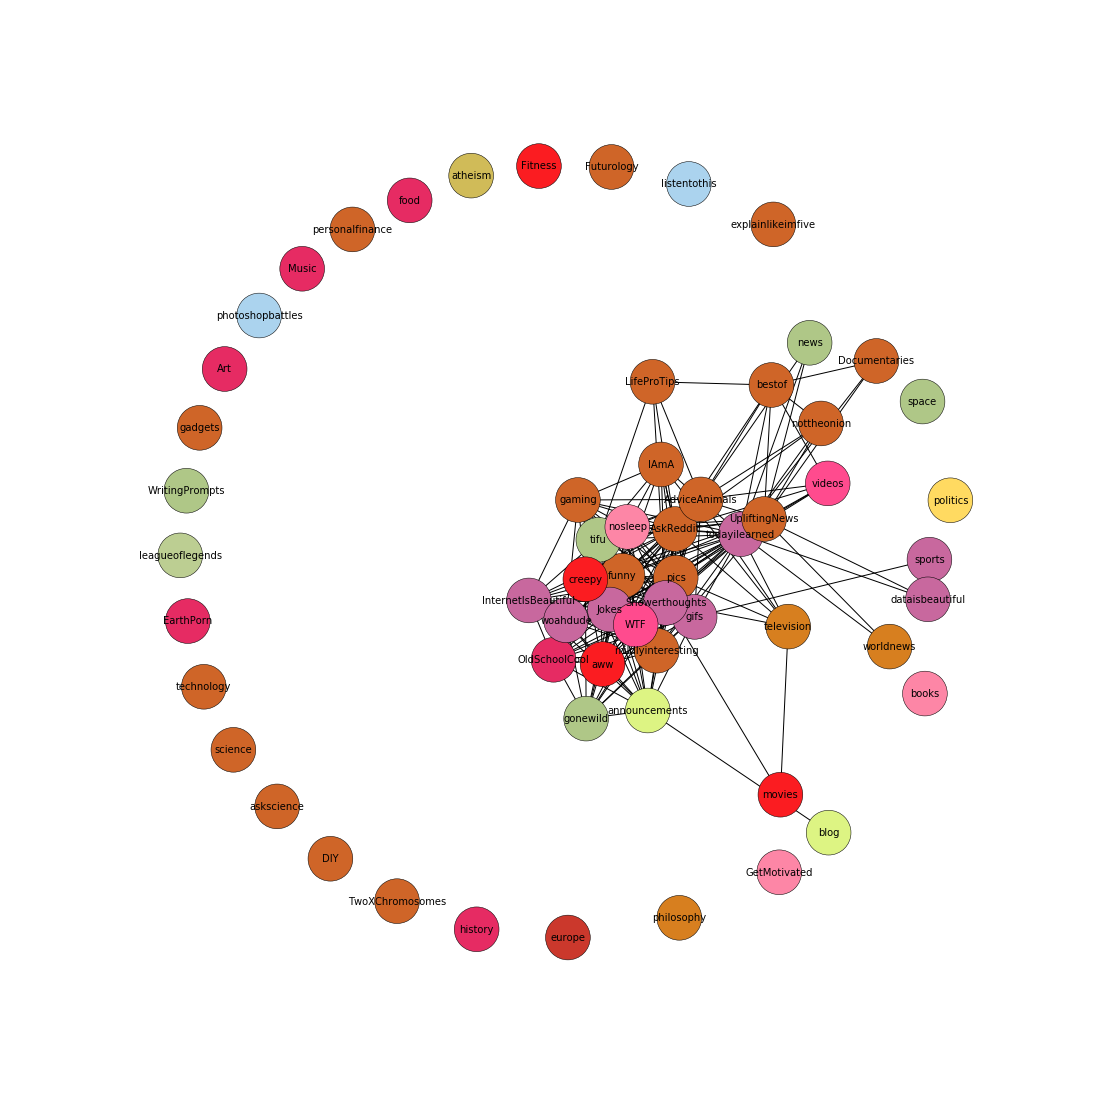

In [61]:
# actually plot everything
fig = plt.figure(figsize=(15,15))
pos=nx.spring_layout(G, scale = 5)
nx.draw(G, labels=labels, 
        node_color = cols, 
        node_shape = 'o',
        node_size = 2000, 
        node_height = 800,
        node_width = 500,
        font_size = 10,
        linewidths=0.5,
        pos=pos)
# plt.savefig("60_20k_fullcolors_TH=180_colorbytopic.png", format="PNG")

4